In [1]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import torch
import json
import os

In [2]:
# some global stuff

# get datapoints
# batch_size = 60
# transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
# test_set = datasets.MNIST('../../data', train=False, transform=transform)
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False)

# device
device = torch.device("cpu")
torch.set_num_threads(4)
# device = torch.device("cuda:2")


def test(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy


def print_active_weights(model):
    nonzero = 0
    total = 0
    for name, p in model.named_parameters():
        if 'weight' in name:
            tensor = p.data.cpu().numpy()
            nz_count = np.count_nonzero(tensor)
            total_params = np.prod(tensor.shape)
            nonzero += nz_count
            total += total_params
            print(f'{name:20} | nonzeros = {nz_count:7} / {total_params:7} ({100 * nz_count / total_params:6.2f}%) | total_pruned = {total_params - nz_count :7} | shape = {tensor.shape}')
    print(f'alive: {nonzero}, pruned : {total - nonzero}, total: {total}, ({100 * nonzero / total:6.2f}% remained)')
    return nonzero / total * 100

In [13]:
# read result summary
import csv
import pandas as pd

csv_filename = "results/result_summary.csv"
# with open(csv_filename, newline='') as f:
#     reader = csv.reader(f)
#     data = list(reader['Sparsity'])
# col_list = ["Sparsity", "Short_warm", "Short_cold", "Long_cold", "Short_no_rewind", "Long_no_rewind"]
# df = pd.read_csv(csv_filename, usecols=col_list)
df = pd.read_csv(csv_filename)

sparsity_list = df['sparsity'].tolist()
short_warm = df['short_warm'].tolist()
short_cold = df['short_cold'].tolist()
short_no_rewind = df['short_no_rewind'].tolist()
long_cold = df['long_cold'].tolist()
long_no_rewind = df['long_no_rewind'].tolist()


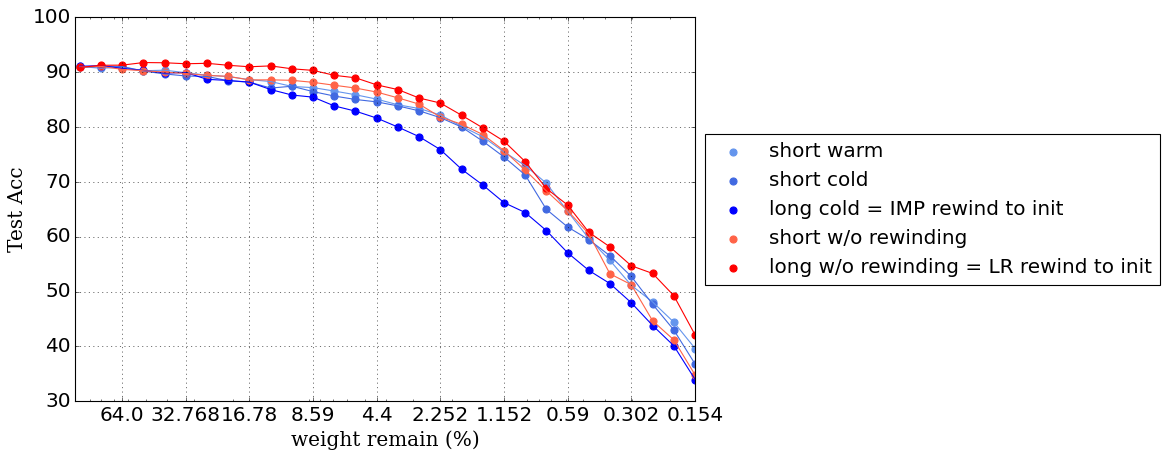

In [16]:
# plot the figure: x = remaining loss, y = test acc
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.style.use("classic")
fig, ax1 = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('white')

# font specification
font_family = 'serif'
fontsize = 18
fontdict = {'family': font_family,
         'color':  'black',
         'weight': 'normal',
         'size': fontsize,
         }

# many ways to specify colors:
# color = 'blue'
# cmap = matplotlib.cm.get_cmap('coolwarm')
# cmap(np.linspace(0, 1, n))  # this gives a list of colors, length n


def plot_a_line(acc_list, label, color):
    # plot LTH
    ax1.scatter(sparsity_list, acc_list, label=label, color=color, s=40)
    # don't comment out this line, this is to connect the point
    ax1.plot(sparsity_list, acc_list, color=color)

plot_a_line(short_warm, "short warm", 'cornflowerblue')
plot_a_line(short_cold, "short cold", 'royalblue')
plot_a_line(long_cold, "long cold = IMP rewind to init", "blue")

plot_a_line(short_no_rewind, "short w/o rewinding", "tomato")
plot_a_line(long_no_rewind, "long w/o rewinding = LR rewind to init", "red")


# specify the plotting range
plt.xlim([0.2, 105])
# plt.ylim([80, 100])

# set label for each axis
ax1.set_xlabel("weight remain (%)", fontdict=fontdict)
ax1.set_ylabel("Test Acc", fontdict=fontdict)

# change the axis tick
plt.tick_params(labelsize=18)
ax1.set_xscale("log", nonpositive='clip')
freq = 3
plt.xticks(sparsity_list[::freq], sparsity_list[::freq])
ax1.grid(True)
ax1.invert_xaxis()  # invert the axis so the left part is large value (e.g. 100)

# NOTE: if use errorbar, uncomment the following to remove the error bar
# handles, labels = ax1.get_legend_handles_labels()
# handles = [h[0] for h in handles]
# lgd = ax1.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), numpoints=1, fontsize=fontsize)
# plt.setp(lgd.texts, family=font_family)
# NOTE: if use scatter, uncomment the following to make sure the legend box is included in the saved figure
lgd = ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1, fontsize=fontsize)

matplotlib.rcParams['figure.dpi'] = 500

plt.savefig("results/result_summary_imp.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')